In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
# sns.set(style="darkgrid")
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve , auc as AUC, confusion_matrix , precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tensorflow import reduce_sum
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.backend import epsilon, log
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, concatenate, Conv2DTranspose, Conv2D, Convolution2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, Reshape, SpatialDropout2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from zipfile import ZipFile




In [2]:
npy_path ='images.npy'
data= np.load(npy_path, allow_pickle=True)
print(data.shape)

(409, 2)


In [3]:
X = data[:,0]
y = data[:,1]
X.shape,y.shape

((409,), (409,))

In [4]:
(width, height, size) = (224, 224, int(X.shape[0]))
y_resized  = np.zeros((size, width, height,3))
X_resized    = np.zeros((size, width, height,3))




for i in range(size):    
    # Reading the image data
    bgr_img = X[i]
    try:
        # Resizing the image
        img = cv2.cvtColor(np.array(bgr_img), cv2.COLOR_BGR2RGB)
        img = img[...,::-1]
        img = cv2.resize(np.array(img), (width,height), interpolation=cv2.INTER_CUBIC) 

        X_resized[i] = img/255
        for j in (y[i]):
            
            (x0,y0,x1,y1) = (int(j['points'][0]['x'] * width), int(j['points'][0]['y'] * height), int(j['points'][1]['x'] * width), int(j['points'][1]['y'] * height))
                        
            if i ==1 :
                print('Masked Data:',j)
                print('\nReplaced pixel range:', x0,y0,x1,y1)
           
            # Replacing all the pixels within masked area with 1                      
            y_resized[i][y0:y1, x0:x1]=  1
            
    except Exception as e:    
        print(e)

Masked Data: {'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}

Replaced pixel range: 157 52 172 81


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_resized, test_size=9, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('\nTraining data : ', X_train.shape, y_train.shape)

print('\nTesting data : ', X_test.shape, y_test.shape)

print('\nValidation data : ', X_val.shape, y_val.shape)



print('\nTraining data =',round(100*X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")

print('\nTesting data  =',round(100*X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")

print('\nValidation data  =',round(100*X_val.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")




Training data :  (320, 224, 224, 3) (320, 224, 224, 3)

Testing data :  (9, 224, 224, 3) (9, 224, 224, 3)

Validation data :  (80, 224, 224, 3) (80, 224, 224, 3)

Training data = 78.24 % of total data

Testing data  = 2.2 % of total data

Validation data  = 19.56 % of total data


36


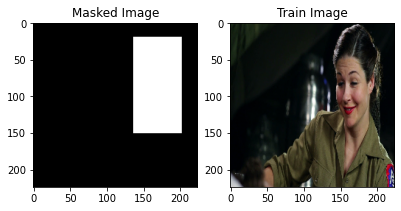

In [6]:
rand = np.random.randint(0, len(X_train), 1) 
rand = int(rand)
print(rand)
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(y_train[rand]);
plt.title('Masked Image')

plt.subplot(1,3,2)
plt.imshow(X_train[rand]);
plt.title('Train Image')

plt.show()

In [7]:
def create_model(base_model):
    model = base_model
    skip = [ "conv_pw_13_relu", "conv_pw_11_relu", "conv_pw_5_relu", 'conv_pw_3_relu', 'conv_pw_1_relu']

    x = model.get_layer(skip[0]).output
    f = [[256,256],[256,256],[192,128],[96,64],[48,32]]

    for i, name in enumerate(skip):
        j = i + 1
        if j < len(skip):
            skip_block = model.get_layer(skip[j]).output
            a = f[i][0]
            b = f[i][1]

            x = Concatenate()([UpSampling2D((2,2))(x), skip_block])

            x = Conv2D(a, (3, 3), padding="same", strides = (1,1), kernel_initializer = 'he_normal')(x) 
            x = BatchNormalization()(x)
            x = Activation("relu")(x)        

            x = Conv2D(b, (3, 3), padding="same", strides = (1,1), kernel_initializer = 'he_normal')(x) 
            x = BatchNormalization()(x)
            x = Activation("relu")(x)  



        else:
            a = f[-1][0]
            b = f[-1][1]
            x = Concatenate()([UpSampling2D((2,2))(x), model.input])
            x = Conv2D(a, (3, 3), padding="same", strides = (1,1), kernel_initializer = 'he_normal')(x) 
            x = BatchNormalization()(x)
            x = Activation("relu")(x) 

            x = Conv2D(b, (3, 3), padding="same", strides = (1,1), kernel_initializer = 'he_normal')(x) 
            x = BatchNormalization()(x)
            x = Activation("relu")(x) 
            x = SpatialDropout2D(0.2)(x)
    
    x = Conv2D(3, (1, 1), activation = 'sigmoid')(x)
    model = Model(model.input, x)
    
    return model

base_model = MobileNet(input_shape = (width, height,3), include_top = False, alpha = 1, weights = 'imagenet')
for layer in base_model.layers:
        layer.trainable = True
model = create_model(base_model)

In [8]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [9]:
adam = Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss=loss, metrics=[dice_coefficient])

print('Count of trainable variables:', len(model.trainable_variables))

model.summary()

Count of trainable variables: 123
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                           

In [10]:
loss0, dice_coef0 = model.evaluate(X_val,y_val)
print('Accuracy: {:.2f}%'.format (100*dice_coef0))

3/3 [==============================] - 30s 8s/step - loss: 2.4118 - dice_coefficient: 0.1979
Accuracy: 19.79%


In [11]:
model_epochs = 5

history1 = model.fit(X_train,y_train,epochs=model_epochs,validation_data=(X_val, y_val))

Epoch 1/5
10/10 [==============================] - 421s 39s/step - loss: 2.1648 - dice_coefficient: 0.2421 - val_loss: 9.4823 - val_dice_coefficient: 0.2292
Epoch 2/5
10/10 [==============================] - 347s 34s/step - loss: 1.7530 - dice_coefficient: 0.3166 - val_loss: 19.0278 - val_dice_coefficient: 0.2236
Epoch 3/5
10/10 [==============================] - 320s 33s/step - loss: 1.5424 - dice_coefficient: 0.3618 - val_loss: 18.6664 - val_dice_coefficient: 0.2310
Epoch 4/5
10/10 [==============================] - 377s 38s/step - loss: 1.4035 - dice_coefficient: 0.3921 - val_loss: 15.9751 - val_dice_coefficient: 0.2386
Epoch 5/5
10/10 [==============================] - 269s 27s/step - loss: 1.3030 - dice_coefficient: 0.4128 - val_loss: 9.3750 - val_dice_coefficient: 0.2810


In [12]:
print('Number of layers in base model:', len(base_model.layers))
print('Number of trainable variables:', len(model.trainable_variables))

Number of layers in base model: 86
Number of trainable variables: 123


In [13]:
adam = Adam(learning_rate = 0.00001)

for layer in base_model.layers[:90]:
    layer.trainable=False
    
model.compile(optimizer= adam, loss=loss, metrics=[dice_coefficient])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

- Model was tuned by setting bottom layers to be untrainable ie fine tuning from layer 90 onwards
- Model was recompiled and trained again to incorporate the changes made

In [14]:
print('Number of trainable variables:', len(model.trainable_variables))
print('\nModel fitting begins')
history2 = model.fit(X_train,y_train,epochs=model_epochs*2, initial_epoch = history1.epoch[-1],validation_data=(X_val, y_val))

Number of trainable variables: 42

Model fitting begins
Epoch 5/10
10/10 [==============================] - 259s 25s/step - loss: 1.2905 - dice_coefficient: 0.4151 - val_loss: 6.0089 - val_dice_coefficient: 0.3103
Epoch 6/10
10/10 [==============================] - 251s 25s/step - loss: 1.2667 - dice_coefficient: 0.4212 - val_loss: 4.0288 - val_dice_coefficient: 0.3451
Epoch 7/10
10/10 [==============================] - 228s 23s/step - loss: 1.2510 - dice_coefficient: 0.4245 - val_loss: 3.0214 - val_dice_coefficient: 0.3685
Epoch 8/10
10/10 [==============================] - 225s 23s/step - loss: 1.2508 - dice_coefficient: 0.4258 - val_loss: 2.3809 - val_dice_coefficient: 0.3868
Epoch 9/10
10/10 [==============================] - 225s 23s/step - loss: 1.2271 - dice_coefficient: 0.4313 - val_loss: 1.9999 - val_dice_coefficient: 0.3986
Epoch 10/10
10/10 [==============================] - 228s 23s/step - loss: 1.2519 - dice_coefficient: 0.4239 - val_loss: 1.7730 - val_dice_coefficient: 0.

In [15]:
loss, dice_coef = model.evaluate(X_test,y_test)
print('Accuracy: {:.2f}%'.format (100*dice_coef))

1/1 [==============================] - 2s 2s/step - loss: 1.9032 - dice_coefficient: 0.4290
Accuracy: 42.90%


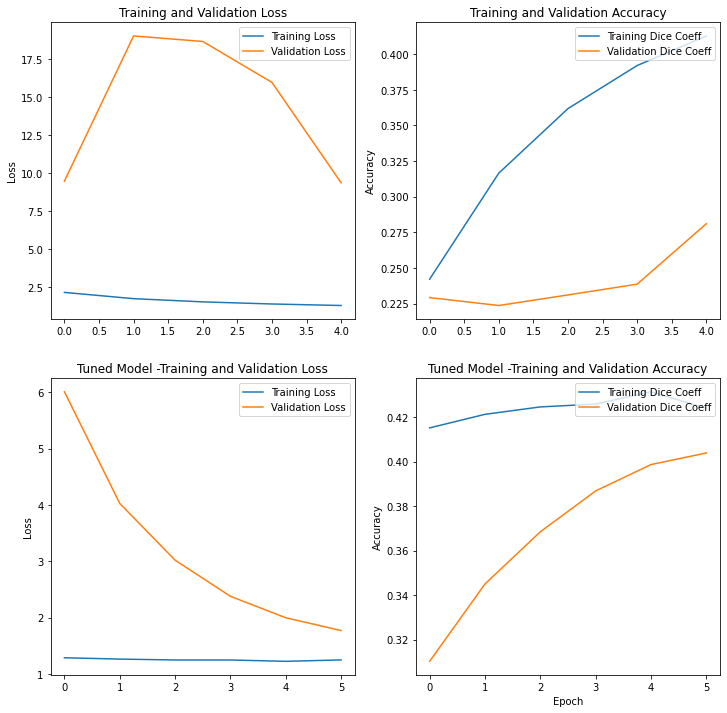

In [16]:
acc = history1.history['dice_coefficient']
val_acc = history1.history['val_dice_coefficient']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(12, 12))

plt.subplot(2,2,1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.title('Training and Validation Loss')


plt.subplot(2,2,2)
plt.plot(acc, label='Training Dice Coeff')
plt.plot(val_acc,label='Validation Dice Coeff')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.title('Training and Validation Accuracy')


acc = history2.history['dice_coefficient']
val_acc = history2.history['val_dice_coefficient']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.subplot(2,2,3)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.title('Tuned Model -Training and Validation Loss')


plt.subplot(2,2,4)
plt.plot(acc, label='Training Dice Coeff')
plt.plot(val_acc,label='Validation Dice Coeff')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.title('Tuned Model -Training and Validation Accuracy')

plt.xlabel('Epoch')

plt.show()

- Learning rate was reduced from 0.0001 to 0.00001 for fine tuning to avoid overfitting
- Bottom layers of the model were made untrainable and model retrained to improve accuracy
- Accuracy improved by 23 percentage points


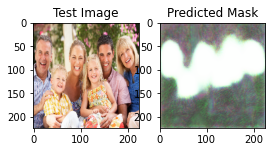

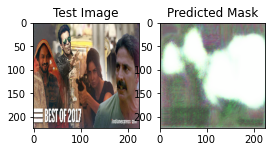

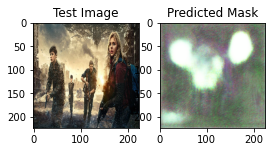

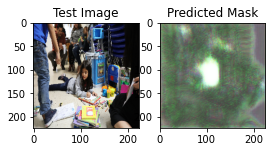

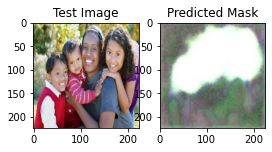

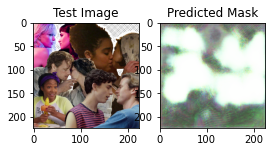

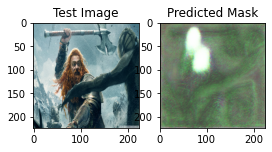

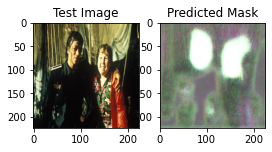

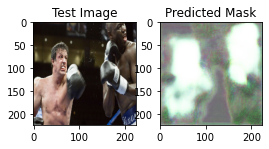

In [17]:
pred_mask = model.predict(X_test)
j = 1
for i in range(len(pred_mask)):
    plt.figure(figsize=(20, 20))
      
    plt.subplot(j,len(pred_mask),1)
    plt.imshow(X_test[i])
    plt.title('Test Image')
    
    plt.subplot(j,len(pred_mask),2)
    plt.imshow(pred_mask[i], alpha=0.75)
    plt.title('Predicted Mask')
    j +=1



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image and predicted mask of test image: ‘image with index 3 


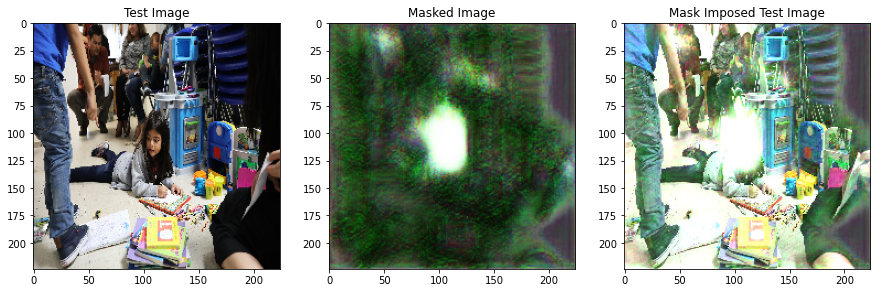

In [20]:
print('Image and predicted mask of test image: ‘image with index 3 ')

n = 3

ip_img = np.asarray(X_test[n], np.float64)
pred_img = np.asarray(pred_mask[n],np.float64)
op_img = cv2.add(ip_img, pred_img)

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(ip_img);
plt.title('Test Image')


plt.subplot(1,3,2)
plt.imshow(pred_img, alpha=1);
plt.title('Masked Image')

plt.subplot(1,3,3)
plt.imshow(op_img);
plt.title('Mask Imposed Test Image')
plt.show()

### 

In [21]:
images_path ='C:\\Users\\Loga\\Downloads\\training_images.zip'

with ZipFile(images_path, 'r') as zip:
    zip.extractall('PartB')

In [22]:
df_face = pd.DataFrame(columns=['x','y','w','h', 'Total_Faces', 'Image_Name', 'Image_Data'])

j = 0;
fpath = 'C:\\Users\\Loga\\Downloads\\PartB\\training_images\\'

for i in os.listdir(fpath):
    
    if i!= '.DS_Store': 
        img = cv2.imread(os.path.join(fpath, i))

        # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        haar_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") 
        faces_rect = haar_cascade.detectMultiScale(gray_img, 1.3, 9)


    for (x, y, w, h) in faces_rect:
      
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

        df_face.loc[len(df_face.index)] = [x , y, w, h, len(faces_rect), i, img]
        
    cv2.waitKey(0)


df_face.to_csv('face.csv', index=False)

In [23]:
df_face[df_face.columns[0:6]].head(10)

,x,y,w,h,Total_Faces,Image_Name
0,37,110,384,384,1,real_00003.jpg
1,122,162,374,374,1,real_00004.jpg
2,59,49,483,483,1,real_00006.jpg
3,263,218,239,239,1,real_00008.jpg
4,84,110,422,422,1,real_00014.jpg
5,66,86,466,466,1,real_00015.jpg
6,90,208,358,358,1,real_00019.jpg
7,70,67,494,494,1,real_00024.jpg
8,95,131,428,428,1,real_00025.jpg
9,28,54,507,507,1,real_00027.jpg


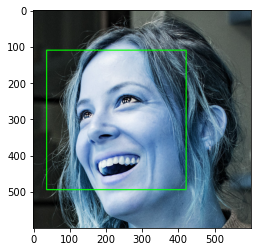

In [24]:
count = df_face.Total_Faces.unique()
for i in count:
    result = df_face['Image_Data'][df_face.Total_Faces==i].head(1)
    plt.imshow(result.values[0])

### 

In [25]:
images_path ='C:\\Users\\Loga\\Downloads\\PINS.zip'
with ZipFile(images_path, 'r') as zip:
    zip.extractall('PartC')

In [26]:
def create_metadata(path):
    width=height=224
    result = pd.DataFrame(columns=['Name','Label','Image'])

    i = 0;
    for path, subdirs, files in os.walk(fpath):
        if path==fpath:
            continue
        label  = os.path.basename(path).replace('pins_','')
        label = label.replace('face', '')
        for name in files:
            file_name = os.path.join(path, name)
            extn = file_name.split('.')[1]
            if (extn == 'jpg' or extn =='png'):
                img = cv2.imread(file_name)
                img = img[...,::-1]
                resized = cv2.resize(img, (width, height))
                result.loc[len(result.index)] = [name , label, resized] 
    return result

In [27]:
fpath = 'C:\\Users\\Loga\\Downloads\\PartC\\PINS\\PINS\\'
df_PINS = create_metadata(fpath)
df_PINS.head(9)

,Name,Label,Image
0,Aaron Paul0_262.jpg,Aaron Paul,"[[[232, 187, 164], [225, 182, 160], [220, 177,..."
1,Aaron Paul101_247.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Aaron Paul101_248.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Aaron Paul101_249.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Aaron Paul103_217.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
5,Aaron Paul113_228.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
6,Aaron Paul114_271.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
7,Aaron Paul116_240.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
8,Aaron Paul117_213.jpg,Aaron Paul,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [28]:
width = height= 224

import h5py 
images_path ='vgg_face_weights.h5'
f1 = h5py.File(images_path, 'r') 

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(width,height, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(images_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [29]:
img_data = np.array(df_PINS.Image)[:9000]
img_data = img_data/255

- Owing to memory limitation, dataset was reduced to contain only 9000 records

In [30]:
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 
vector = vgg_face.predict(np.expand_dims(img_data[0], axis=0))[0]

In [31]:
embed_face =[]
embed_face = np.zeros((len(img_data),vector.shape[0]))
for i in range(len(img_data)):
    embed_face[i] = vgg_face.predict(np.expand_dims(img_data[i], axis=0))[0]

In [32]:
def euclidean_distance(x, y):
    return np.sum(np.square(x -y))

Similarity distance: 0.27756010569773215


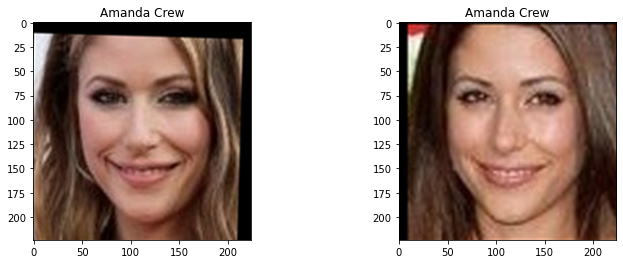

In [33]:
distance = euclidean_distance(embed_face[500], embed_face[502])
print('Similarity distance:',distance)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(img_data[500])

plt.title(df_PINS.Label[500])


plt.subplot(1,2,2)
plt.imshow(img_data[502])

plt.title(df_PINS.Label[502]);


Similarity distance: 1.0698049749480387


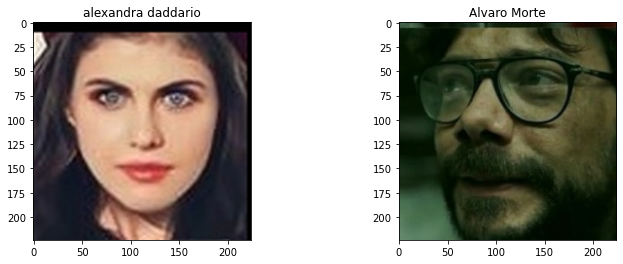

In [34]:
distance = euclidean_distance(embed_face[151], embed_face[312])
print('Similarity distance:',distance)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(img_data[151])

plt.title(df_PINS.Label[151])


plt.subplot(1,2,2)
plt.imshow(img_data[312])

plt.title(df_PINS.Label[312]);


- The lower the euclidean distance, the higher the similarity


In [35]:
#Split X and y from PINS data
X = df_PINS.index[:9000]
y = df_PINS['Label'][:9000]

#Encode labels
lencoder   = LabelEncoder()
y  = lencoder.fit_transform(y)


#Split PINS data to extract indices for train/test
train_x, test_x, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Load image data from extracted list of indices
X_train = np.array(embed_face)[train_x]
X_test = np.array(embed_face)[test_x]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('\nTraining data : ', X_train.shape, y_train.shape)  

print('\nTesting data : ', X_test.shape, y_test.shape) 

print('\nValidation data : ', X_val.shape, y_val.shape) 

print('\nTraining data =',round(100*X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")

print('\nTesting data  =',round(100*X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")

print('\nValidation data  =',round(100*X_val.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0]),2),"% of total data")


#Standardise features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)
X_val_stand = scaler.transform(X_val)


Training data :  (5760, 2622) (5760,)

Testing data :  (1800, 2622) (1800,)

Validation data :  (1440, 2622) (1440,)

Training data = 64.0 % of total data

Testing data  = 20.0 % of total data

Validation data  = 16.0 % of total data


The number of dimensions required to preserve 95.0 % of variance is 330


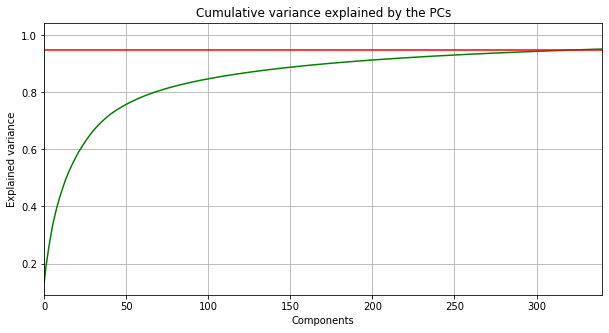

In [36]:
threshold = 0.95

pca= PCA()

pca.fit(X_train_stand)

cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= threshold) + 1
print('The number of dimensions required to preserve', 100* threshold, '% of variance is',dim)

plt.figure(figsize=(10, 5))
plt.plot(cumsum, color = 'green')


plt.axhline(threshold, color='red')
plt.axvline(np.argmax(cumsum >= 0.99) + 1)

plt.title('Cumulative variance explained by the PCs')
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.xlim(0,dim+10)


plt.grid(b=True, linestyle='-')


In [37]:
pca = PCA(n_components= dim, svd_solver='full', whiten=True) 
x_train = pca.fit_transform(X_train_stand)
x_test = pca.transform(X_test_stand)
x_val = pca.transform(X_val_stand)

In [38]:
SVM_Classifier = SVC(C=1, kernel='rbf', gamma=0.001, class_weight='balanced')
SVM_Classifier.fit(x_train, y_train)
SVM_pred = SVM_Classifier.predict(x_val)
score = (y_val, SVM_pred)
score

(array([28, 58, 24, ..., 22, 79, 54]), array([28, 58, 24, ..., 34, 79, 54]))

In [42]:
pred_test = SVM_Classifier.predict(x_test)

report = pd.DataFrame(classification_report( y_test, pred_test, output_dict=True)).transpose()
dict_keys =list(report.keys())

for x in report.index:
    if(x.strip().isdigit()):
        new = lencoder.inverse_transform([int(x)])
        report.rename(index={x:new[0]},inplace=True)

report

,precision,recall,f1-score,support
Aaron Paul,1.000000,1.000000,1.000000,17.000000
Alvaro Morte,0.857143,1.000000,0.923077,18.000000
Amanda Crew,1.000000,0.958333,0.978723,24.000000
Amaury Nolasco,1.000000,1.000000,1.000000,23.000000
Anna Gunn,1.000000,0.769231,0.869565,13.000000
...,...,...,...,...
rihanna,1.000000,1.000000,1.000000,24.000000
robert downey jr,0.952381,0.952381,0.952381,21.000000
accuracy,0.963889,0.963889,0.963889,0.963889
macro avg,0.968780,0.961294,0.963864,1800.000000


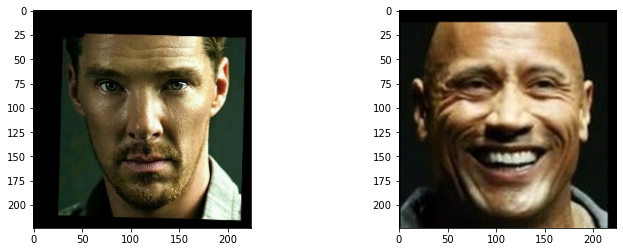

In [43]:
test_path ='Benedict Cumberbatch9.jpg'

pred_img1 = cv2.imread(test_path)
pred_img1 = pred_img1[...,::-1]
pred_img1 = cv2.resize(pred_img1,(width,height),3)
pred_img1 = pred_img1/255
pred_img1.astype('float32')

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pred_img1)

test_path ='Dwayne Johnson4.jpg'
pred_img2 = cv2.imread(test_path)
pred_img2 = pred_img2[...,::-1]
pred_img2 = cv2.resize(pred_img2,(width,height),3)
pred_img2 = pred_img2/255
pred_img2.astype('float32')
plt.subplot(1,2,2)
plt.imshow(pred_img2)

plt.show()

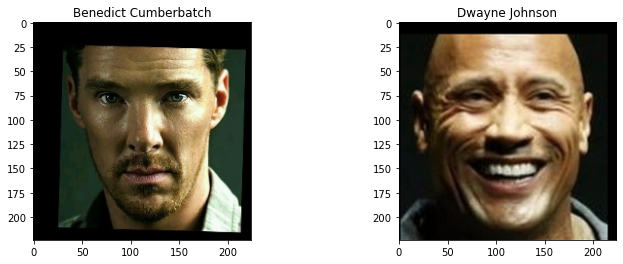

In [44]:
em_vec1 = vgg_face.predict(np.expand_dims(pred_img1, axis=0))[0]
em_vec1 = em_vec1.reshape(1,-1)
x_pred1 =  scaler.transform(em_vec1) 
x_pred1 = pca.transform(x_pred1)

    

pred1 = SVM_Classifier.predict(x_pred1)
label1 = lencoder.inverse_transform([pred1])[0]

em_vec2 = vgg_face.predict(np.expand_dims(pred_img2, axis=0))[0]
em_vec2 = em_vec2.reshape(1,-1)
x_pred2 =  scaler.transform(em_vec2) 
x_pred2 = pca.transform(x_pred2)

    

pred2 = SVM_Classifier.predict(x_pred2)
label2 = lencoder.inverse_transform([pred2])[0]


plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pred_img1)
plt.title(label1)

plt.subplot(1,2,2)
plt.imshow(pred_img2)
plt.title(label2)

plt.show()